**Stress Prediction [XGBoost | Optuna | SHAP]**

In [1]:
# pip install --upgrade ipywidgets jupyter kagglehub[pandas-datasets] matplotlib nbformat optuna plotly seaborn shap xgboost

In [2]:
# @title
from IPython.display import display, HTML

with open("header.html", "r") as f:
    display(HTML(f.read()))

<h1 style="text-align: center;">Spis Treści</h1>

<div style="display: flex; justify-content: center;">
  <div style="text-align: left; background-color: #f9f9f9; padding: 20px 30px; border-radius: 10px; border: 1px solid #ddd; width: fit-content; font-size: 16px; line-height: 1.8;">

<ol>
  <li><a href="#wprowadzenie">Wprowadzenie</a></li>
  <li><a href="#wczytywanie-danych">Wczytywanie danych</a></li>
  <li><a href="#feature-engineering-/-eda">Feature Engineering / EDA</a></li>
  <li><a href="#modelowanie">Modelowanie</a></li>
  <li><a href="#optymalizacja-hiperparametrów">Optymalizacja hiperparametrów</a></li>
  <li><a href="#interpretacja-rezultatów">Interptretacja rezultatów</a></li>
</ol>

  </div>
</div>

<p style="text-align: center; font-size: 14px; color: gray;">⬆️ Kliknij linki, aby przejść do wybranej sekcji</p>

## Wprowadzenie

> **Temat projektu:**
> Model predykcyjny dotyczących prognozy poziomu stresu z wykorzystaniem raportu **Stress Level Prediction** oraz danych dotyczących metryk snu i stylu życia **Sleep Health and Lifestyle Dataset** dostępnych na platformie [Kaggle](https://www.kaggle.com)

<p align="center">
  <img src="Sleep_Health_and_Lifestyle_Dataset.png" width="450"/>
</p>

-------------------------------------------------------------------------------------------------------------------------------------------

## Wczytywanie danych
Wczytujemy dataset ze stress level prediction (KaggleHub), wyświetlamy pierwsze obserwacje oraz upewniamy się, że kolumny są poprawne.

In [3]:
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly
import seaborn as sns
import shap
from kagglehub import KaggleDatasetAdapter
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from xgboost import XGBClassifier

from utils import time_to_float, plot_boxplots, plot_kde_by_stress_level, plot_correlation_heatmap, plot_stress_level_class_balance, plot_confusion_matrix

In [4]:
file_path = "stress_detection_data.csv"

df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "shijo96john/stress-level-prediction",
  file_path,
)

-------------------------------------------------------------------------------------------------------------------------------------------

<h1 style="text-align: center;">Koniec rozdziału: Wczytywanie danych</h1>

<div style="display: flex; justify-content: center;">
  <div style="text-align: left; background-color: #f9f9f9; padding: 20px 30px; border-radius: 10px; border: 1px solid #ddd; width: fit-content; font-size: 16px; line-height: 1.8;">

<ol>
  <li><a href="#wprowadzenie">Wprowadzenie</a></li>
  <li><a href="#wczytywanie-danych">Wczytywanie danych</a></li>
  <li><a href="#feature-engineering-/-eda">Feature Engineering / EDA</a></li>
  <li><a href="#modelowanie">Modelowanie</a></li>
  <li><a href="#optymalizacja-hiperparametrów">Optymalizacja hiperparametrów</a></li>
  <li><a href="#interpretacja-rezultatów">Interptretacja rezultatów</a></li>
</ol>

  </div>
</div>

<p style="text-align: center; font-size: 14px; color: gray;">⬆️ Kliknij linki, aby przejść do wybranej sekcji</p>

-------------------------------------------------------------------------------------------------------------------------------------------

## Feature Engineering / EDA

In [5]:
pd.set_option('display.max_columns', None)
df.head()

,Age,Gender,Occupation,Marital_Status,Sleep_Duration,Sleep_Quality,Wake_Up_Time,Bed_Time,Physical_Activity,Screen_Time,Caffeine_Intake,Alcohol_Intake,Smoking_Habit,Work_Hours,Travel_Time,Social_Interactions,Meditation_Practice,Exercise_Type,Blood_Pressure,Cholesterol_Level,Blood_Sugar_Level,Stress_Detection
0,30,Male,Software Engineer,Single,7.0,4.0,7:00 AM,10:00 PM,2.0,4.0,1,0,No,8,1.0,5,Yes,Cardio,120,180,90,Low
1,35,Female,Marketing Manager,Married,6.0,3.0,6:00 AM,11:00 PM,1.0,3.0,0,1,No,9,2.0,3,No,Yoga,110,160,80,Medium
2,40,Male,Data Scientist,Divorced,7.0,4.0,7:00 AM,10:00 PM,2.0,4.0,1,0,No,8,1.0,5,Yes,Strength Training,130,200,100,High
3,35,Male,Software Engineer,Single,7.0,4.0,7:00 AM,10:00 PM,2.0,4.0,1,0,No,8,1.0,5,Yes,Cardio,120,180,90,Low
4,29,Female,Teacher,Single,8.0,5.0,6:30 AM,10:30 PM,3.0,2.0,1,0,No,7,1.0,4,Yes,Yoga,110,180,90,Low


In [6]:
df.isnull().sum()

Age                    0
Gender                 0
Occupation             0
Marital_Status         0
Sleep_Duration         0
Sleep_Quality          0
Wake_Up_Time           0
Bed_Time               0
Physical_Activity      0
Screen_Time            0
Caffeine_Intake        0
Alcohol_Intake         0
Smoking_Habit          0
Work_Hours             0
Travel_Time            0
Social_Interactions    0
Meditation_Practice    0
Exercise_Type          0
Blood_Pressure         0
Cholesterol_Level      0
Blood_Sugar_Level      0
Stress_Detection       0
dtype: int64

W zbiorze nie ma brakujących wartości.

In [7]:
df.describe()

,Age,Sleep_Duration,Sleep_Quality,Physical_Activity,Screen_Time,Caffeine_Intake,Alcohol_Intake,Work_Hours,Travel_Time,Social_Interactions,Blood_Pressure,Cholesterol_Level,Blood_Sugar_Level
count,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000
mean,38.887451,6.338422,3.848124,2.979301,4.105433,1.818887,0.888745,8.258732,2.858344,3.196636,137.943079,220.834411,111.765847
std,7.686642,0.733584,0.545459,0.797234,0.812513,0.838396,0.673741,1.064168,1.083758,0.856332,13.122060,19.322622,12.533097
min,18.000000,3.500000,2.000000,1.000000,2.000000,0.000000,0.000000,6.000000,0.500000,1.000000,110.000000,150.000000,80.000000
25%,33.000000,6.000000,3.600000,2.000000,4.000000,1.000000,0.000000,8.000000,2.000000,3.000000,130.000000,210.000000,105.000000
50%,39.000000,6.300000,3.900000,3.000000,4.000000,2.000000,1.000000,8.000000,3.000000,3.000000,140.000000,220.000000,115.000000
75%,45.000000,7.000000,4.000000,4.000000,5.000000,2.000000,1.000000,9.000000,4.000000,4.000000,150.000000,230.000000,120.000000
max,60.000000,8.000000,5.000000,5.000000,8.000000,4.000000,2.000000,14.000000,5.000000,5.000000,170.000000,290.000000,150.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 773 entries, 0 to 772
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  773 non-null    int64  
 1   Gender               773 non-null    object 
 2   Occupation           773 non-null    object 
 3   Marital_Status       773 non-null    object 
 4   Sleep_Duration       773 non-null    float64
 5   Sleep_Quality        773 non-null    float64
 6   Wake_Up_Time         773 non-null    object 
 7   Bed_Time             773 non-null    object 
 8   Physical_Activity    773 non-null    float64
 9   Screen_Time          773 non-null    float64
 10  Caffeine_Intake      773 non-null    int64  
 11  Alcohol_Intake       773 non-null    int64  
 12  Smoking_Habit        773 non-null    object 
 13  Work_Hours           773 non-null    int64  
 14  Travel_Time          773 non-null    float64
 15  Social_Interactions  773 non-null    int

In [9]:
STRESS_LEVEL_TO_LABEL = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}
LABEL_TO_STRESS_LEVEL = {v: k for k, v in STRESS_LEVEL_TO_LABEL.items()}

df['Stress_Detection'] = df['Stress_Detection'].map(STRESS_LEVEL_TO_LABEL)

In [10]:
df["Bed_Time"] = df["Bed_Time"].astype(str)
df["Wake_Up_Time"] = df["Wake_Up_Time"].astype(str)
df["Bed_Time_float"] = df["Bed_Time"].apply(time_to_float)
df["Wake_Up_Time_float"] = df["Wake_Up_Time"].apply(time_to_float)
df["Bed_Time_sin"] = np.sin(2 * np.pi * df["Bed_Time_float"] / 24)
df["Bed_Time_cos"] = np.cos(2 * np.pi * df["Bed_Time_float"] / 24)
df["Wake_Up_Time_sin"] = np.sin(2 * np.pi * df["Wake_Up_Time_float"] / 24)
df["Wake_Up_Time_cos"] = np.cos(2 * np.pi * df["Wake_Up_Time_float"] / 24)

df['Time_In_Bed'] = np.where(
    df['Wake_Up_Time_float'] < df['Bed_Time_float'],
    (24 - df['Bed_Time_float']) + df['Wake_Up_Time_float'],
    df['Wake_Up_Time_float'] - df['Bed_Time_float'],
)
df["Sleep_Interruption"] = df["Time_In_Bed"] - df["Sleep_Duration"]

columns_to_drop = ["Bed_Time", "Wake_Up_Time", "Bed_Time_float", "Wake_Up_Time_float", "Time_In_Bed"]
df = df.drop(columns=columns_to_drop)

Zauważono, że różnica między godziną pójścia spać, a godziną wstania z łóżka nie jest tożsama z faktyczną długością snu, stąd została stworzona cecha Sleep Interruption informująca o zakłóceniach snu w ciągu nocy. Same godziny przekonwertowano do postaci cyklicznej przy użyciu sinusa i cosinusa, aby model dostrzegał bliskość wartości godzinowych typu 23:59 oraz 00:01.

In [11]:
df.head()

,Age,Gender,Occupation,Marital_Status,Sleep_Duration,Sleep_Quality,Physical_Activity,Screen_Time,Caffeine_Intake,Alcohol_Intake,Smoking_Habit,Work_Hours,Travel_Time,Social_Interactions,Meditation_Practice,Exercise_Type,Blood_Pressure,Cholesterol_Level,Blood_Sugar_Level,Stress_Detection,Bed_Time_sin,Bed_Time_cos,Wake_Up_Time_sin,Wake_Up_Time_cos,Sleep_Interruption
0,30,Male,Software Engineer,Single,7.0,4.0,2.0,4.0,1,0,No,8,1.0,5,Yes,Cardio,120,180,90,0,-0.500000,0.866025,0.965926,-2.588190e-01,2.0
1,35,Female,Marketing Manager,Married,6.0,3.0,1.0,3.0,0,1,No,9,2.0,3,No,Yoga,110,160,80,1,-0.258819,0.965926,1.000000,6.123234e-17,1.0
2,40,Male,Data Scientist,Divorced,7.0,4.0,2.0,4.0,1,0,No,8,1.0,5,Yes,Strength Training,130,200,100,2,-0.500000,0.866025,0.965926,-2.588190e-01,2.0
3,35,Male,Software Engineer,Single,7.0,4.0,2.0,4.0,1,0,No,8,1.0,5,Yes,Cardio,120,180,90,0,-0.500000,0.866025,0.965926,-2.588190e-01,2.0
4,29,Female,Teacher,Single,8.0,5.0,3.0,2.0,1,0,No,7,1.0,4,Yes,Yoga,110,180,90,0,-0.382683,0.923880,0.991445,-1.305262e-01,0.0


In [12]:
categorical_cols = [col for col in df.select_dtypes(include=['object']).columns]
print(categorical_cols)

for col in categorical_cols:
    df[col] = df[col].astype('category')

['Gender', 'Occupation', 'Marital_Status', 'Smoking_Habit', 'Meditation_Practice', 'Exercise_Type']


In [13]:
# Zbieramy tylko kolumny numeryczne (bez targetu)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != "Stress_Detection"]

outlier_report = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_report[col] = len(outliers)

# Wyświetlanie raportu
print("Wynik raportu dotyczącego Outlier'ów:\n")
for col, count in outlier_report.items():
    print(f"{col}: {count} outliers")

Wynik raportu dotyczącego Outlier'ów:

Age: 0 outliers
Sleep_Duration: 28 outliers
Sleep_Quality: 83 outliers
Physical_Activity: 0 outliers
Screen_Time: 12 outliers
Caffeine_Intake: 2 outliers
Alcohol_Intake: 0 outliers
Work_Hours: 30 outliers
Travel_Time: 0 outliers
Social_Interactions: 1 outliers
Blood_Pressure: 0 outliers
Cholesterol_Level: 39 outliers
Blood_Sugar_Level: 19 outliers
Bed_Time_sin: 0 outliers
Bed_Time_cos: 0 outliers
Wake_Up_Time_sin: 55 outliers
Wake_Up_Time_cos: 0 outliers
Sleep_Interruption: 0 outliers


Dostrzegamy pewne wartości odstające, więc tworzymy wykresy boxplot, żeby je zwizualizować.

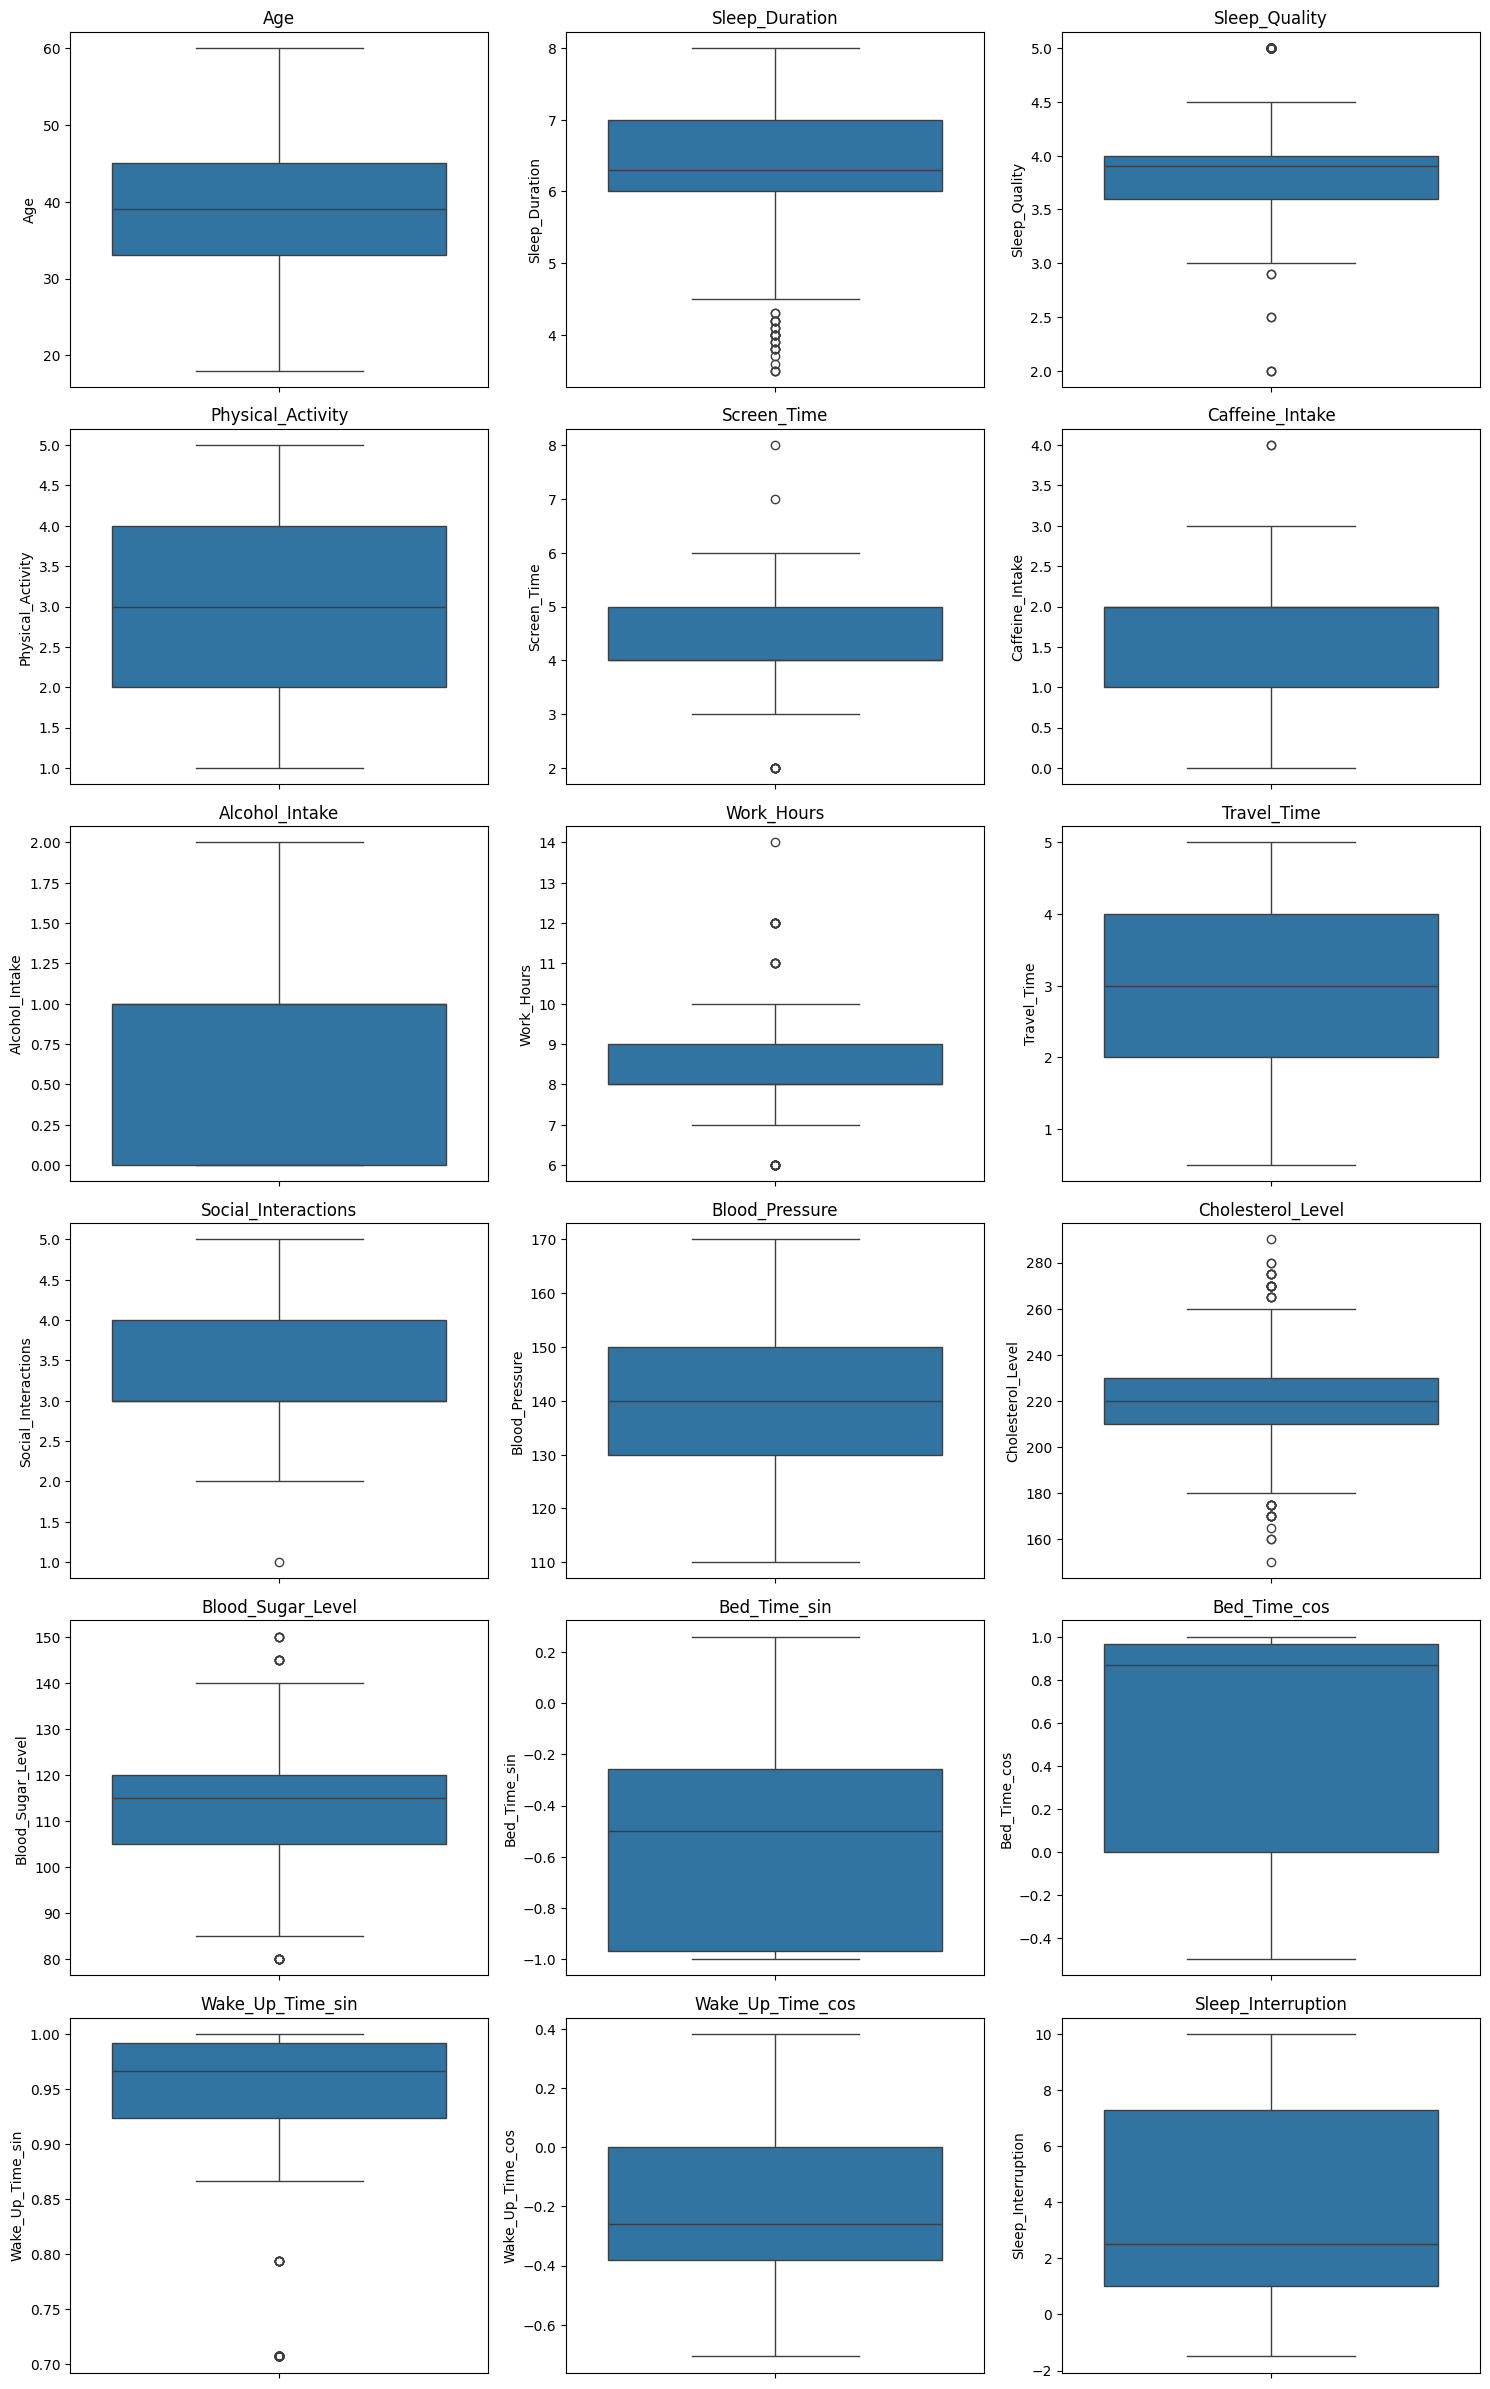

In [14]:
plot_boxplots(df, numeric_cols)

Wartości odstające są możliwe do zaistnienia w rzeczywistości (np. ekstremalne wartości jakości snu lub godzin pracy) i nie mają znamion błędów wprowadzania danych, dlatego nie są usuwane ze zbioru.

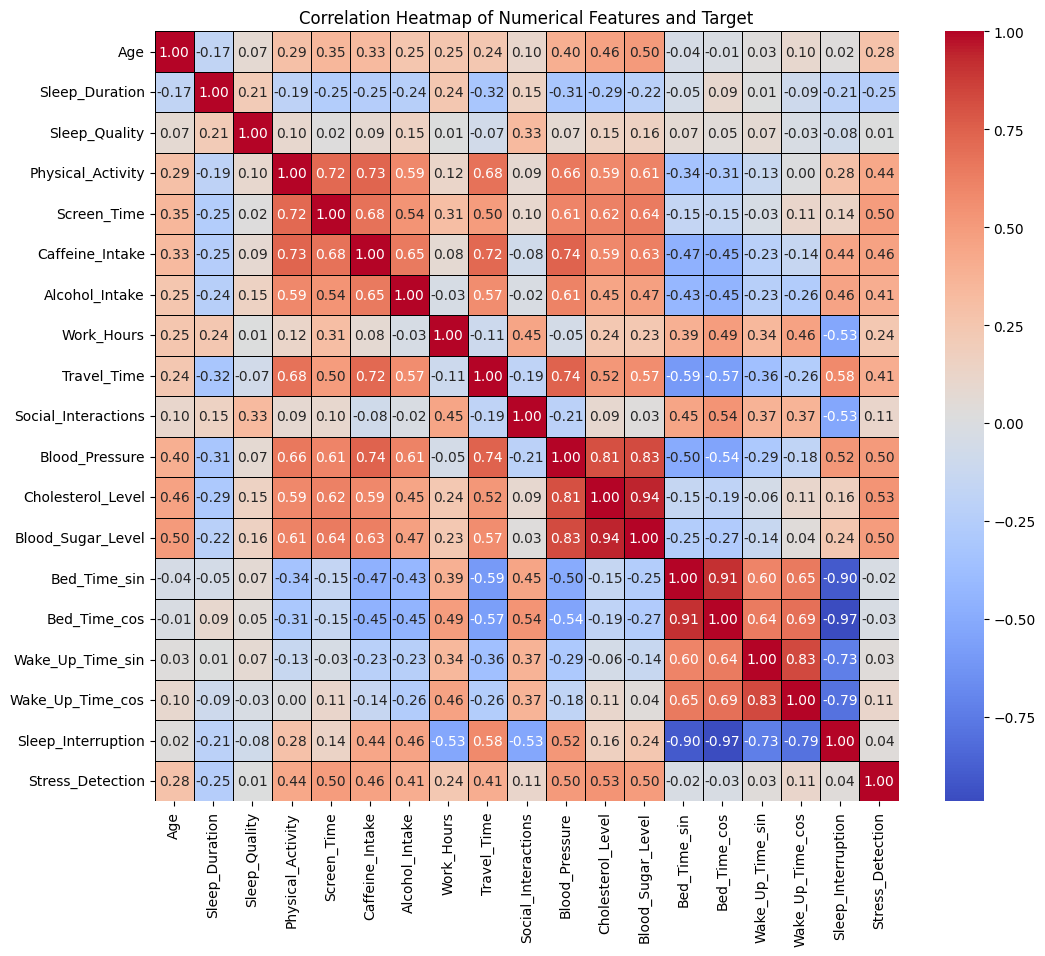

In [15]:
correlation_matrix = df[numeric_cols + ["Stress_Detection"]].corr()

plot_correlation_heatmap(correlation_matrix)

Z macierzy korelacji możemy odczytać między innymi zależności względem badanego poziomu stresu - są to poziom cholesterolu (0.53), poziom cukru (0.50), ciśnienie krwi (0.50), czy czas spędzony przed ekranem (0.50). Dostrzegamy także bardzo wysoką korelację wzajemną pomiędzy pierwszymi trzema wspomnianymi cechami. 

In [16]:
df["Health_Risk_Score"] = (df["Blood_Pressure"] + df["Cholesterol_Level"] + df["Blood_Sugar_Level"]) / 3
redundant_health_cols = ["Blood_Pressure", "Cholesterol_Level", "Blood_Sugar_Level"]
df = df.drop(columns=redundant_health_cols)

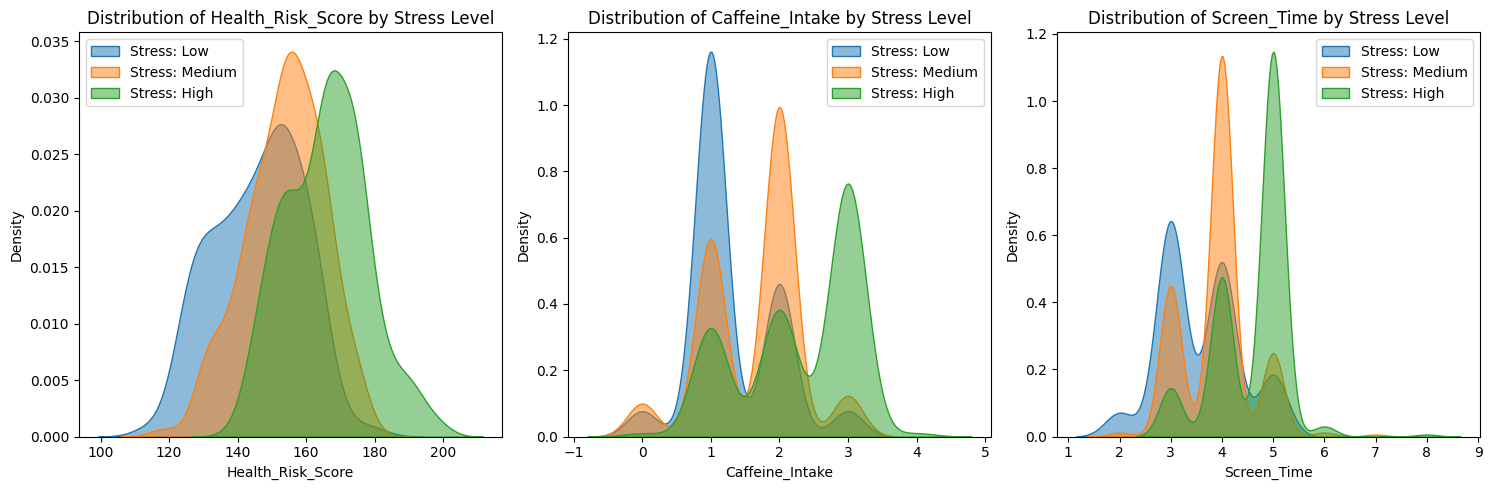

In [17]:
key_features = [
    'Health_Risk_Score', 
    'Caffeine_Intake', 
    'Screen_Time',
]

plot_kde_by_stress_level(df, key_features, LABEL_TO_STRESS_LEVEL)

Wykresy rozkładu gęstości całkiem wyraźnie pokazują rozróżnienie pomiędzy trzema klasami oznaczającymi poziom stresu. Zarówno wskaźnik ryzyka zdrowotnego (średnia cholesterolu, ciśnienia i cukru we krwi), zażytej kofeiny, jak i czasu spędzonego przed ekranem dla wysokich wartości charakteryzuje wysoki poziom stresu.

CLASS BALANCE

Counts:
Stress_Detection
1    310
2    301
0    162
Name: count, dtype: int64

Percentage:
Stress_Detection
1    40.10%
2    38.94%
0    20.96%
Name: proportion, dtype: object


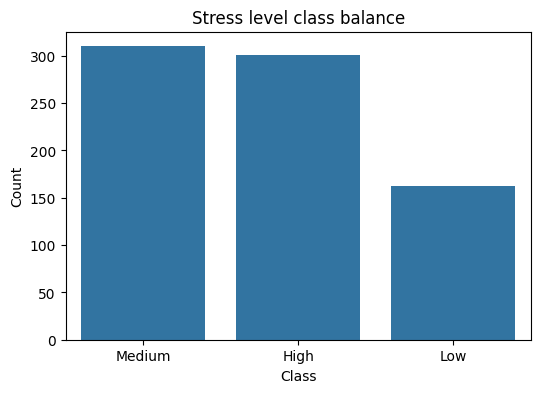

In [18]:
class_counts = df["Stress_Detection"].value_counts()
class_percent = df["Stress_Detection"].value_counts(normalize=True) * 100

print("CLASS BALANCE\n")
print("Counts:")
print(class_counts)
print("\nPercentage:")
print(class_percent.map(lambda x: f"{x:.2f}%"))

plot_stress_level_class_balance(class_counts, LABEL_TO_STRESS_LEVEL)

Dostrzegamy, że klasy nie są idealnie zbilansowane - próbek o niskim poziomie stresu jest dwa razy mniej niż każdej z pozostałych.

-------------------------------------------------------------------------------------------------------------------------------------------

<h1 style="text-align: center;">Koniec rozdziału: Wczytywanie danych</h1>

<div style="display: flex; justify-content: center;">
  <div style="text-align: left; background-color: #f9f9f9; padding: 20px 30px; border-radius: 10px; border: 1px solid #ddd; width: fit-content; font-size: 16px; line-height: 1.8;">

<ol>
  <li><a href="#wprowadzenie">Wprowadzenie</a></li>
  <li><a href="#wczytywanie-danych">Wczytywanie danych</a></li>
  <li><a href="#feature-engineering-/-eda">Feature Engineering / EDA</a></li>
  <li><a href="#modelowanie">Modelowanie</a></li>
  <li><a href="#optymalizacja-hiperparametrów">Optymalizacja hiperparametrów</a></li>
  <li><a href="#interpretacja-rezultatów">Interptretacja rezultatów</a></li>
</ol>

  </div>
</div>

<p style="text-align: center; font-size: 14px; color: gray;">⬆️ Kliknij linki, aby przejść do wybranej sekcji</p>

-------------------------------------------------------------------------------------------------------------------------------------------

## Modelowanie

W tej części projektu budujemy pierwszy, bazowy model do przewidywania poziomu stresu na podstawie cech związanych ze stylem życia, snem, aktywnością i informacjami demograficznymi.
Po wcześniejszym przygotowaniu danych (czyszczenie, inżynieria cech, kodowanie kategorii) przechodzimy do:
- wydzielenia danych treningowych i testowych,

- zbudowania klasyfikatora XGBoost,

- przetrenowania go na danych,

- oceny jakości modelu przy użyciu metryki accuracy.

Ten etap ma na celu zbudowanie baseline modelu (modelu referencyjnego), który później będziemy ulepszać przy użyciu Optuny, SHAP oraz bardziej zaawansowanej inżynierii cech.

In [19]:
target = 'Stress_Detection'
X = df.drop(columns=[target])
y = df[target]

seed = 42
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed) 

model = XGBClassifier(enable_categorical=True) 
model.fit(X_train, y_train)

print(model)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy * 100.0:.2f}%")
print(f"Macro F1-score: {macro_f1 * 100.0:.2f}%")

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)
Accuracy: 69.92%
Macro F1-score: 67.39%


-------------------------------------------------------------------------------------------------------------------------------------------

<h1 style="text-align: center;">Koniec rozdziału: Modelowanie</h1>

<div style="display: flex; justify-content: center;">
  <div style="text-align: left; background-color: #f9f9f9; padding: 20px 30px; border-radius: 10px; border: 1px solid #ddd; width: fit-content; font-size: 16px; line-height: 1.8;">

<ol>
  <li><a href="#wprowadzenie">Wprowadzenie</a></li>
  <li><a href="#wczytywanie-danych">Wczytywanie danych</a></li>
  <li><a href="#feature-engineering-/-eda">Feature Engineering / EDA</a></li>
  <li><a href="#modelowanie">Modelowanie</a></li>
  <li><a href="#optymalizacja-hiperparametrów">Optymalizacja hiperparametrów</a></li>
  <li><a href="#interpretacja-rezultatów">Interptretacja rezultatów</a></li>
</ol>

  </div>
</div>

<p style="text-align: center; font-size: 14px; color: gray;">⬆️ Kliknij linki, aby przejść do wybranej sekcji</p>

-------------------------------------------------------------------------------------------------------------------------------------------

## Optymalizacja hiperparametrów

W tym fragmencie kodu wykorzystujemy bibliotekę Optuna do automatycznej optymalizacji hiperparametrów modelu XGBoost. Zamiast ręcznie dobierać wartości takie jak max_depth, learning_rate czy n_estimators, Optuna sama przeszukuje przestrzeń parametrów i wybiera kombinacje dające najlepszy wynik.
Do oceny każdej konfiguracji używamy walidacji krzyżowej (StratifiedKFold), aby uzyskać stabilny, wiarygodny wynik niezależny od pojedynczego splitu danych.

In [20]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),  # default: 100 
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # default: 3
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # default: 1
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # default: 0.1
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # default: 1
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # default: 1
        'gamma': trial.suggest_float('gamma', 0, 5),  # default: 0
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),  # default: 0
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),  # default: 1
        'enable_categorical': True
    }
    
    clf = XGBClassifier(**param)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred_cv = cross_val_predict(clf, X_train, y_train, n_jobs=-1, cv=skf)
    macro_f1 = f1_score(y_train, y_pred_cv, average='macro')
    return macro_f1


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=400)

trial = study.best_trial

print(f'Best Macro F1-score: {trial.value * 100:.2f}%')
print(f"Best hyperparameters: {trial.params}")

[I 2025-11-28 22:03:09,393] A new study created in memory with name: no-name-6c48d945-804e-4294-829e-a26deecdf630
[I 2025-11-28 22:03:14,081] Trial 0 finished with value: 0.44281572061385743 and parameters: {'n_estimators': 395, 'max_depth': 9, 'min_child_weight': 3, 'learning_rate': 0.20642646893229252, 'subsample': 0.900770966901778, 'colsample_bytree': 0.5270561262065563, 'gamma': 4.500407798965817, 'reg_alpha': 7.0672439044509545, 'reg_lambda': 5.2999513949789545}. Best is trial 0 with value: 0.44281572061385743.
[I 2025-11-28 22:03:17,309] Trial 1 finished with value: 0.6306180996749621 and parameters: {'n_estimators': 465, 'max_depth': 5, 'min_child_weight': 6, 'learning_rate': 0.14849258435672652, 'subsample': 0.964321255074547, 'colsample_bytree': 0.7665866196307466, 'gamma': 0.5092637838770103, 'reg_alpha': 1.2105270241743993, 'reg_lambda': 6.888552090691061}. Best is trial 1 with value: 0.6306180996749621.
[I 2025-11-28 22:03:17,640] Trial 2 finished with value: 0.54808959156

Best Macro F1-score: 66.65%
Best hyperparameters: {'n_estimators': 195, 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.18204464035387302, 'subsample': 0.9514333974908388, 'colsample_bytree': 0.6889846558320434, 'gamma': 0.24173674290191494, 'reg_alpha': 0.28909985448671005, 'reg_lambda': 2.8083333872517158}


In [21]:
optuna.visualization.plot_optimization_history(study)

In [22]:
optuna.visualization.plot_parallel_coordinate(study)

Po zakończeniu procesu strojenia hiperparametrów za pomocą Optuna, otrzymujemy zestaw najlepszych parametrów (trial.best_params). Kolejnym krokiem jest wytrenowanie finalnego modelu XGBoost z tymi optymalnymi ustawieniami i sprawdzenie, jak poradzi sobie na danych testowych, czyli takich, których model wcześniej nie widział. Ten etap pozwala ocenić, czy optymalizacja rzeczywiście zwiększyła jakość predykcji.

In [23]:
best_params = trial.params
best_params['enable_categorical'] = True

best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

y_pred_best = best_model.predict(X_test)
acc_best = accuracy_score(y_test, y_pred_best)
macro_f1_best = f1_score(y_test, y_pred_best, average='macro')

print(f"Test accuracy with best hyperparameters: {acc_best * 100:.2f}%")
print(f"Macro F1-score with best hyperparameters: {macro_f1_best * 100:.2f}%")

Test accuracy with best hyperparameters: 71.88%
Macro F1-score with best hyperparameters: 69.55%


Wskutek retreningu modelu na wytypowanych przez Optunę hiperparametrach zaobserwowaliśmy wzrost dokładności oraz wskaźnika macro F1 score zastosowanego ze względu na niezbilansowanie klas.

              precision    recall  f1-score   support

         Low      0.737     0.491     0.589        57
      Medium      0.682     0.750     0.714       100
        High      0.750     0.818     0.783        99

    accuracy                          0.719       256
   macro avg      0.723     0.686     0.695       256
weighted avg      0.720     0.719     0.713       256



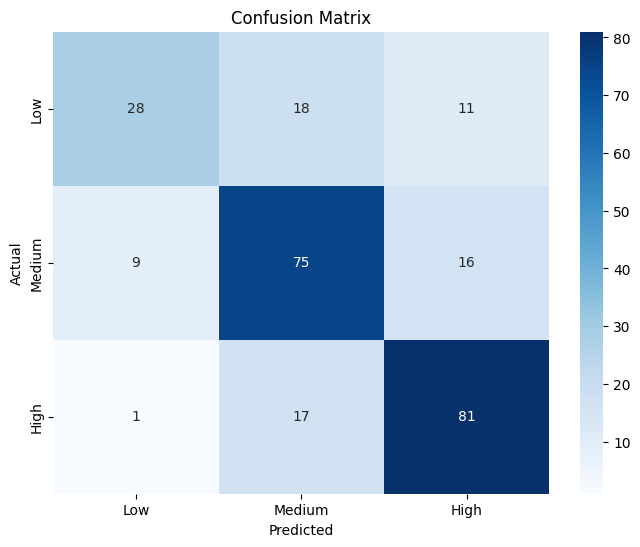

In [24]:
print(classification_report(y_test, y_pred_best, 
                          target_names=['Low', 'Medium', 'High'],
                          digits=3))

cm = confusion_matrix(y_test, y_pred_best)
plot_confusion_matrix(cm, STRESS_LEVEL_TO_LABEL.keys())

Model ma wysoką skuteczność w trafianiu klasy "Low", ale wychwytuje stosunkowo niewiele próbek. Z kolei najlepiej rozpoznaje klasę "High". Najczęściej myli się na rzecz sąsiadującej klasy. 

-------------------------------------------------------------------------------------------------------------------------------------------

<h1 style="text-align: center;">Koniec rozdziału: Optymalizacja hiperparametrów</h1>

<div style="display: flex; justify-content: center;">
  <div style="text-align: left; background-color: #f9f9f9; padding: 20px 30px; border-radius: 10px; border: 1px solid #ddd; width: fit-content; font-size: 16px; line-height: 1.8;">

<ol>
  <li><a href="#wprowadzenie">Wprowadzenie</a></li>
  <li><a href="#wczytywanie-danych">Wczytywanie danych</a></li>
  <li><a href="#feature-engineering-/-eda">Feature Engineering / EDA</a></li>
  <li><a href="#modelowanie">Modelowanie</a></li>
  <li><a href="#optymalizacja-hiperparametrów">Optymalizacja hiperparametrów</a></li>
  <li><a href="#interpretacja-rezultatów">Interptretacja rezultatów</a></li>
</ol>

  </div>
</div>

<p style="text-align: center; font-size: 14px; color: gray;">⬆️ Kliknij linki, aby przejść do wybranej sekcji</p>

-------------------------------------------------------------------------------------------------------------------------------------------

## Interpretacja rezultatów

Biblioteka SHAP (SHapley Additive exPlanations) pozwala obliczyć, które cechy mają największy wpływ na decyzje modelu. Dzięki temu możemy ustalić m.in. jakie elementy stylu życia najbardziej wpływają na poziom stresu.

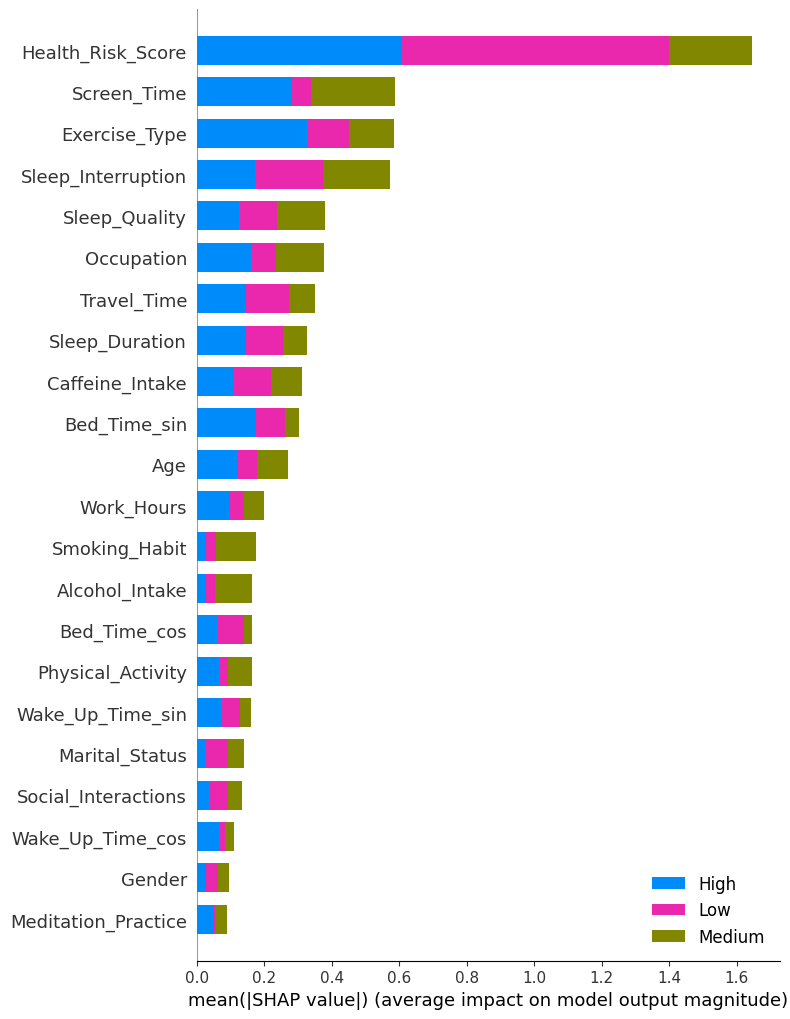

In [34]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=50,
                  class_names=[LABEL_TO_STRESS_LEVEL[i] for i in range(len(LABEL_TO_STRESS_LEVEL))],
                  )

Powyższy wykres informuje o cechach mających największy wpływ na wynik klasyfikacji - są to kolejno Health_Risk_Score (wskaźnik ryzyka zdrowotnego), Occupation (stanowisko) oraz Sleep_Interruption (ilość godzin w łóżku bez snu).

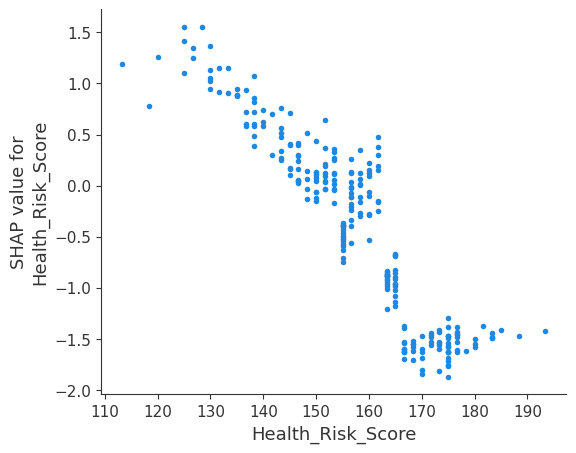

<Figure size 640x480 with 0 Axes>

In [26]:
chosen_class = 0
chosen_feature = 'Health_Risk_Score'

shap.dependence_plot(
    chosen_feature,
    shap_values[:, :, chosen_class],
    X_test,
    interaction_index=None,
)
plt.tight_layout()
plt.show()

Dla klasy "Low" oznaczającej osoby o niskim poziomie stresu można zaobserwować trend, iż wraz ze wzrostem parametrów zagrożenia zdrowia (ciśnienia krwi, cukru, cholesterolu), wartość SHAP bardzo szybko maleje. Oznacza to, że wyższe wartości Health Risk Score obniżają prawdopodobieństwo predykcji tej klasy.

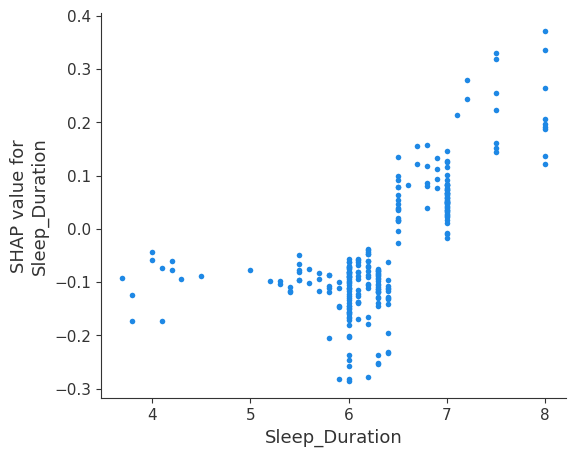

<Figure size 640x480 with 0 Axes>

In [27]:
chosen_class = 0
chosen_feature = 'Sleep_Duration'

shap.dependence_plot(
    chosen_feature,
    shap_values[:, :, chosen_class],
    X_test,
    interaction_index=None,
)
plt.tight_layout()
plt.show()

Przynajmniej 7,5h snu silnie warunkuje zaklasyfikowanie obserwacji do zbioru niskiego poziomu stresu.

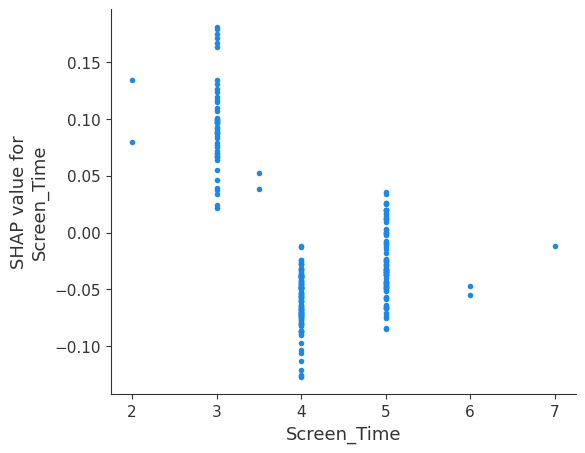

<Figure size 640x480 with 0 Axes>

In [28]:
chosen_class = 0
chosen_feature = 'Screen_Time'

shap.dependence_plot(
    chosen_feature,
    shap_values[:, :, chosen_class],
    X_test,
    interaction_index=None,
)
plt.tight_layout()
plt.show()

Zbyt długie przebywanie przed ekranem obniża szansę na predykcję "Low Stress", natomiast wpływ ten jest znacząco mniejszy niż ciśnienie krwi, czy długość snu.

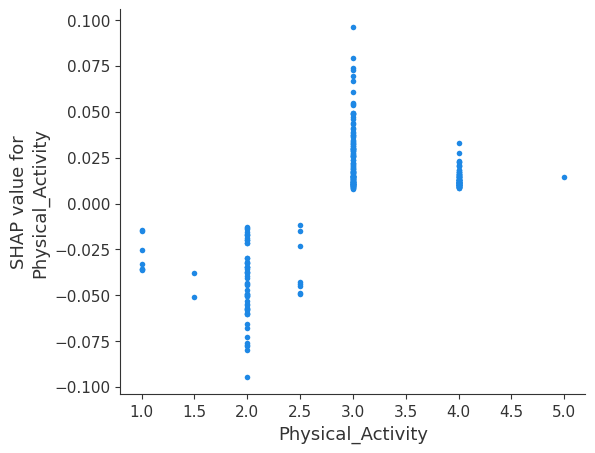

<Figure size 640x480 with 0 Axes>

In [29]:
chosen_class = 0
chosen_feature = 'Physical_Activity'

shap.dependence_plot(
    chosen_feature,
    shap_values[:, :, chosen_class],
    X_test,
    interaction_index=None,
)
plt.tight_layout()
plt.show()

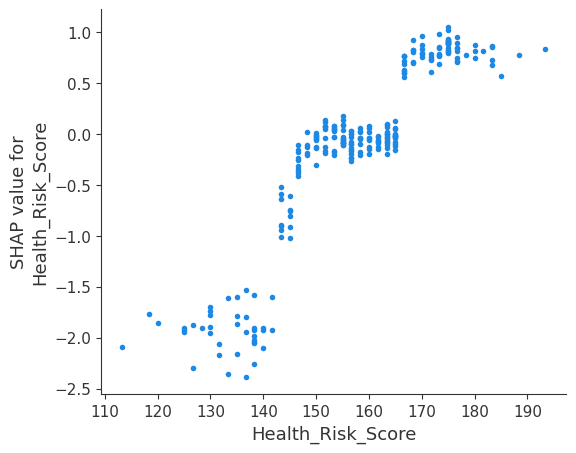

<Figure size 640x480 with 0 Axes>

In [35]:
chosen_class = 2
chosen_feature = 'Health_Risk_Score'

shap.dependence_plot(
    chosen_feature,
    shap_values[:, :, chosen_class],
    X_test,
    interaction_index=None,
)
plt.tight_layout()
plt.show()

Wysoki wkaźnik zagrożenia zdrowia bardzo wyraźnie zwiększa prawdopodobieństwo uzyskania klasy "High Stress Level" (wartość SHAP rośnie wraz z poziomem Health Risk Score dla wybranej klasy 2).

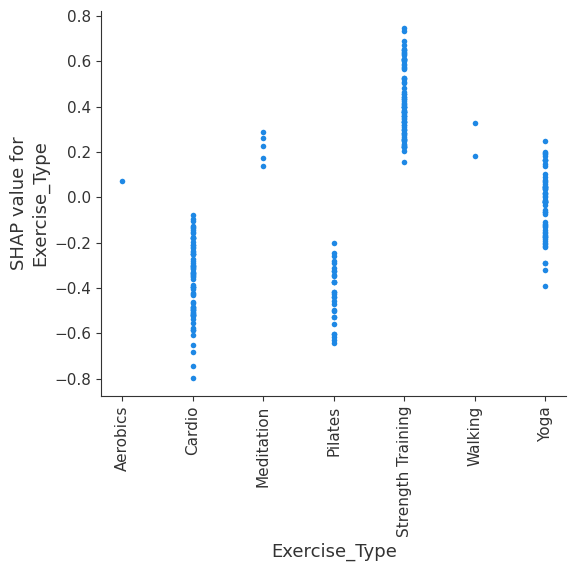

<Figure size 640x480 with 0 Axes>

In [31]:
chosen_class = 2
chosen_feature = 'Exercise_Type'

shap.dependence_plot(
    chosen_feature,
    shap_values[:, :, chosen_class],
    X_test,
    interaction_index=None,
)
plt.tight_layout()
plt.show()

Trening Cardio, Pilates i Joga zmniejszają poziom stresu, natomiast treningi siłowe go podnoszą.

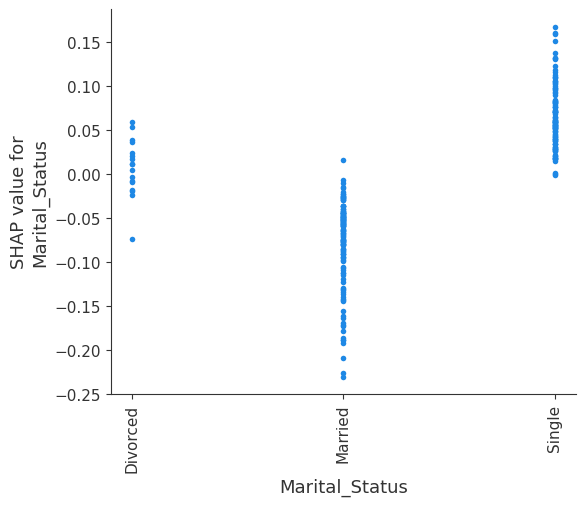

<Figure size 640x480 with 0 Axes>

In [32]:
chosen_class = 0
chosen_feature = 'Marital_Status'

shap.dependence_plot(
    chosen_feature,
    shap_values[:, :, chosen_class],
    X_test,
    interaction_index=None,
)
plt.tight_layout()
plt.show()

Na podstawie powyższego wykresu można wywnioskować, że single są częściej klasyfikowani do grupy niskiego poziomu stresu. Natomiast dla zestresowanych osób już będących w związku rozwód nie jest rozwiązaniem, gdyż nie podwyższa on znacząco prawdopodobieństwa na zaklasyfikowanie do grupy "Low Stress" :)

Waterfall plot for sample id 42, class "Low" of Stress_Level


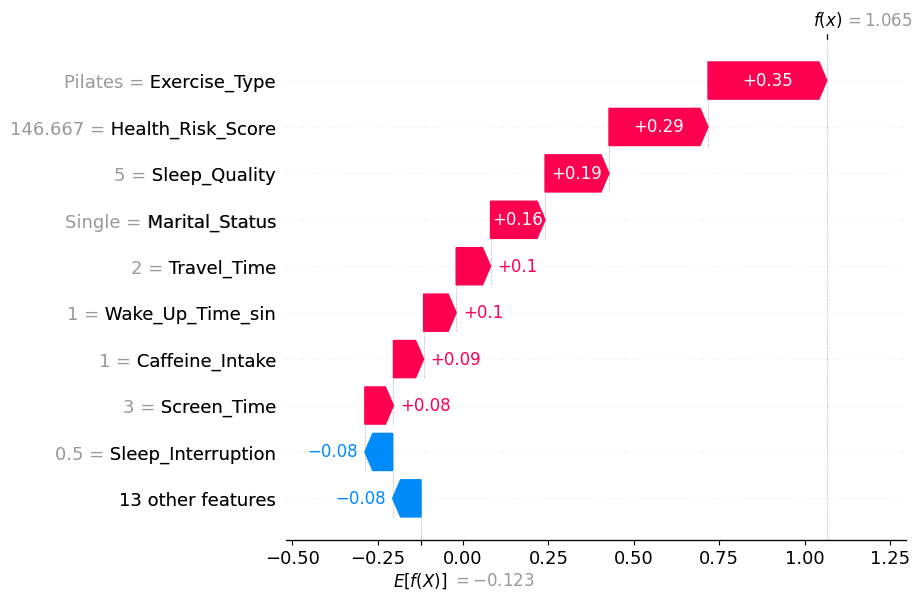

In [33]:
feature_names = X_test.columns.tolist()

sample_idx = 42
predicted_class = y_pred_best[sample_idx]

exp = shap.Explanation(
    values=shap_values[sample_idx, :, predicted_class],
    base_values=explainer.expected_value[predicted_class],
    data=X_test.iloc[sample_idx].values,
    feature_names=feature_names
)

print(f"Waterfall plot for sample id {sample_idx}, class \"{LABEL_TO_STRESS_LEVEL[predicted_class]}\" of Stress_Level")
shap.plots.waterfall(exp)
plt.show()

Bazowa wartość dla klasy "Low" jest ujemna (mniej prawdopodobna), natomiast dla danej obserwacji cechy wyraźnie podnoszą spodziewaną wartość f(x) wskutek czego wybrana jako predykcja została właśnie ta klasa i z wysokim prawdopodobieństwem jest ona prawidłowa (wysoka wartość f(x)).

-------------------------------------------------------------------------------------------------------------------------------------------

<h1 style="text-align: center;">Koniec rozdziału: Interpretacja rezultatów</h1>

<div style="display: flex; justify-content: center;">
  <div style="text-align: left; background-color: #f9f9f9; padding: 20px 30px; border-radius: 10px; border: 1px solid #ddd; width: fit-content; font-size: 16px; line-height: 1.8;">

<ol>
  <li><a href="#wprowadzenie">Wprowadzenie</a></li>
  <li><a href="#wczytywanie-danych">Wczytywanie danych</a></li>
  <li><a href="#feature-engineering-/-eda">Feature Engineering / EDA</a></li>
  <li><a href="#modelowanie">Modelowanie</a></li>
  <li><a href="#optymalizacja-hiperparametrów">Optymalizacja hiperparametrów</a></li>
  <li><a href="#interpretacja-rezultatów">Interptretacja rezultatów</a></li>
</ol>

  </div>
</div>

<p style="text-align: center; font-size: 14px; color: gray;">⬆️ Kliknij linki, aby przejść do wybranej sekcji</p>

-------------------------------------------------------------------------------------------------------------------------------------------